# Calculating the FIM Matrix

This notebook calculates the FIM matrix for a small MLP after learning the toy dataset.

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import pickle

from utils import mlp,vgg,train_test_model
from utils.ewc_utils.ToyExampleEWC_test import FullEWC, LowRankEWC, MinorDiagonalEWC, BlockDiagonalEWC
from utils.ewc_utils.ToyExampleEWC_test import SketchEWC

from data.sequential_lines import Lines

from sklearn.decomposition import TruncatedSVD

from data.permuted_MNIST import get_permuted_mnist
from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
input_size = [1,28,28]
conv_kernel_sizes = [2,2,4,4,4,4]
fc_sizes = [50]

In [94]:
class Model(nn.Module):
    def __init__(self, input_size, conv_kernel_sizes, nofclasses=10,drop_rate=.2,activation='ReLU'):
        super(Model, self).__init__()
        self.nofclasses = nofclasses
        self.numofchannels = input_size[0]
        self.activation=nn.ReLU(inplace=True)      
        
        self.drop_rate=drop_rate
            
        self.conv_layers=list()
        for i,kernel_size in enumerate(conv_kernel_sizes):
            if i==0:
                self.conv_layers.append(nn.Conv2d(self.numofchannels,kernel_size,kernel_size=3,padding=1))
                self.conv_layers.append(nn.BatchNorm2d(kernel_size * 1))
                self.conv_layers.append(self.activation)
            else:
                self.conv_layers.append(nn.Conv2d(conv_kernel_sizes[i-1],kernel_size,kernel_size=3,padding=1))
                self.conv_layers.append(nn.BatchNorm2d(kernel_size))
                self.conv_layers.append(self.activation)
                if i%2:
                    self.conv_layers.append(nn.MaxPool2d(2,2))
        # We need to register parameters, this can be easily done with Sequential
        self.features = nn.Sequential(*self.conv_layers)

        dummy=torch.rand(([1]+input_size))
        dummy=self.features(dummy)    
#         print(dummy.shape)
        d=self.num_flat_features(dummy)
#         print(d)
        
        self.classify=nn.Sequential(nn.Linear(d,self.nofclasses))



    def num_flat_features(self,x):
        return torch.prod(torch.as_tensor(x.size()[1:]))

    def forward(self,x):           
        x=self.features(x)
#         print(x.shape)
        x = x.view(-1,self.num_flat_features(x) )
#         print(x.shape
        x=self.classify(x)
        return x

#     def classifier(self,x):
#         x=self.forward(x)
#         x=self.classify(x)
#         return x

In [95]:
model = Model(input_size,conv_kernel_sizes)

In [96]:
print(model)

Model(
  (activation): ReLU(inplace=True)
  (features): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [111]:
d=0
for n, p in model.named_parameters():
    print(p.data.view(-1).shape[0])
    d+=p.data.view(-1).shape[0]
print(d)

18
2
2
2
36
2
2
2
72
4
4
4
144
4
4
4
144
4
4
4
144
4
4
4
360
10
988


In [98]:
epochs = 20
lr = 1e-4
batch_size = 100
input_size = 784
hidden_sizes = [50,50]
output_size = 10

seed = 0

num_task = 1
n_bucket = 50

activation='ReLU'
device='cuda:0'

ewc_alpha=0.25
ewc_importance=1e+4

In [99]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

torch.Size([100, 1, 28, 28])


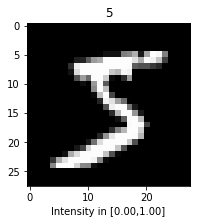

In [100]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    print(image.shape)
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax.imshow(I,cmap='gray')
    ax.set_title(label.data[0].numpy())
    ax.set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

In [101]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
# model = mlp.MLP(input_size=input_size,output_size=output_size,
#               hidden_size=hidden_sizes,activation=activation,
#               device=device).to(device)
## performing training
loss, acc = {}, {}
for task in range(num_task):
    loss[task] = []
    acc[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))                           
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                  data_loader=test_loader[sub_task],
                                                                  device=device))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


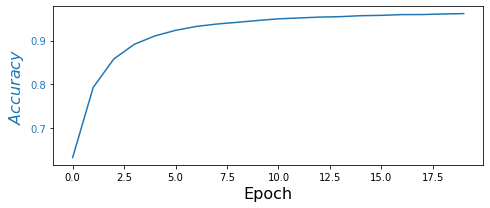

In [113]:
fig, ax1 = plt.subplots(figsize=(7,3))
fontsize=16
color = 'C0'
ax1.set_xlabel('Epoch',fontsize=fontsize)
ax1.set_ylabel(r'$Accuracy$', color=color,fontsize=fontsize)
ax1.plot(np.asarray(acc[sub_task]), color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [114]:
acc[sub_task][-1]

0.9618

In [103]:
def calculate_FIM(model: nn.Module, 
                  data_loader: torch.utils.data.DataLoader):
    
    device="cuda:0"
    model.eval()
    grad=[]
    for n, p in model.named_parameters():
        grad.append(p.grad.data.view(-1))            
    grad=torch.cat(grad)
    d=grad.shape[0]
    A=torch.zeros((d,d))
        
    for i,(imgs,labels) in tqdm_notebook(enumerate(data_loader)):
        model.zero_grad() # Zero the gradients
        imgs,labels = imgs.to(device),labels.to(device)# Get Inout
        
        loss_list=nn.CrossEntropyLoss(reduction='none')(model(imgs),labels)
        for loss in tqdm_notebook(loss_list):
            model.zero_grad() # Zero the gradients
            loss.backward(retain_graph=True)
            grad=[]
            for n, p in model.named_parameters():
                grad.append(p.grad.data.view(-1))
            grad=torch.cat(grad)
            A+=torch.matmul(grad.unsqueeze(1).to("cpu"),grad.unsqueeze(0).to("cpu"))
    A=A/float(len(data_loader.dataset))
    return A

In [104]:
A=calculate_FIM(model=model,data_loader=train_loader[task])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [64]:
results_folder = "Error_Analysis/"
np.save(open(results_folder+'FIM.npy','wb'),A)

In [105]:
sketch_ewc = SketchEWC(model, device, alpha=.25, n_sketch=50)
B = sketch_ewc.calculate_approximation(train_loader[task])

In [106]:
((A-B)**2).sum()/(A**2).sum()

tensor(0.1682)

In [109]:
block_diagonal = BlockDiagonalEWC(model, device, alpha=.25)
C = block_diagonal.calculate_approximation(train_loader[task])

In [110]:
((A-C)**2).sum()/(A**2).sum()

tensor(0.6748)

In [7]:
print(diagonal_error.mean(), diagonal_error.std())
print(block_diagonal_error.mean(), block_diagonal_error.std())
print(sketched_error.mean(), sketched_error.std())
print(low_rank_error.mean(), low_rank_error.std())
# print(np.array(stable_rank).mean(), np.array(stable_rank).std())

0.94711936 0.006053829
0.8287951 0.013002222
0.08082563 0.10188777
3.0142753e-11 4.8421198e-11
